In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.5 MB/s eta 0:00:00


<h1>Galaxy Classification</>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import zscore
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, average_precision_score, roc_curve, log_loss, mean_absolute_error, mean_squared_error, r2_score)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
from scipy import stats
import joblib
import optuna
import pickle
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xudhanxhu","key":"9513a1a19be7e20ff95078acdb990f93"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bryancimo/sdss-galaxy-classification-dr18

Dataset URL: https://www.kaggle.com/datasets/bryancimo/sdss-galaxy-classification-dr18
License(s): CC0-1.0
  0% 0.00/18.4M [00:00<?, ?B/s]
100% 18.4M/18.4M [00:00<00:00, 1.09GB/s]


In [ ]:
!unzip /content/sdss-galaxy-classification-dr18.zip -d /content/

Archive:  /content/sdss-galaxy-classification-dr18.zip
  inflating: /content/sdss_100k_galaxy_form_burst.csv  


In [ ]:
!rm -rf /content/sdss-galaxy-classification-dr18.zip

In [ ]:
!ls /content/

sample_data  sdss_100k_galaxy_form_burst.csv


In [ ]:
df = pd.read_csv('sdss_100k_galaxy_form_burst.csv', skiprows=1)
print(df.shape)
df.head()

(100000, 43)


objid            specobjid          ra       dec           u  \
0  1237646587710669400  8175185722644649984   82.038679  0.847177    21.73818   
1  1237646588247540577  8175186822156277760   82.138894  1.063072    20.66761   
2  1237646588247540758  8175187097034184704   82.028510  1.104003    23.63531   
3  1237648702973083853   332152325571373056  198.544469 -1.097059    20.12374   
4  1237648702973149350   332154249716721664  198.706864 -1.046217 -9999.00000   

            g         r         i         z  modelFlux_u  ...  psfMag_z  \
0    20.26633  19.32409  18.64037  18.23833     2.007378  ...  19.43575   
1    19.32016  18.67888  18.24693  18.04122     5.403369  ...  18.85012   
2    21.19671  19.92297  19.31443  18.68396     0.295693  ...  19.42235   
3    18.41520  17.47202  17.05297  16.72423     8.920645  ...  18.03204   
4 -9999.00000  18.37762  18.13383  17.78497     0.000000  ...  19.02880   

       expAB_u      expAB_g   expAB_r   expAB_i   expAB_z   class  \
0     0.099951     0.311864  0.289370  0.270588  0.187182  GALAXY   
1     0.366549     0.516876  0.517447  0.552297  0.636966  GALAXY   
2     0.050000     0.417137  0.506950  0.549881  0.370166  GALAXY   
3     0.310763     0.356827  0.389345  0.388160  0.416660  GALAXY   
4 -9999.000000 -9999.000000  0.050000  0.050000  0.149973  GALAXY   

      subclass  redshift  redshift_err  
0  STARFORMING  0.067749      0.000015  
1  STARFORMING  0.105118      0.000010  
2  STARFORMING  0.234089      0.000030  
3  STARFORMING  0.110825      0.000030  
4  STARFORMING  0.136658      0.000021  

[5 rows x 43 columns]

In [ ]:
df.columns

Index(['objid', 'specobjid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z',
       'modelFlux_u', 'modelFlux_g', 'modelFlux_r', 'modelFlux_i',
       'modelFlux_z', 'petroRad_u', 'petroRad_g', 'petroRad_i', 'petroRad_r',
       'petroRad_z', 'petroFlux_u', 'petroFlux_g', 'petroFlux_i',
       'petroFlux_r', 'petroFlux_z', 'petroR50_u', 'petroR50_g', 'petroR50_i',
       'petroR50_r', 'petroR50_z', 'psfMag_u', 'psfMag_r', 'psfMag_g',
       'psfMag_i', 'psfMag_z', 'expAB_u', 'expAB_g', 'expAB_r', 'expAB_i',
       'expAB_z', 'class', 'subclass', 'redshift', 'redshift_err'],
      dtype='object')

In [ ]:
df['subclass'].value_counts()

subclass
STARFORMING    74993
STARBURST      25007
Name: count, dtype: int64

In [ ]:
df.drop(columns=['objid', 'specobjid', 'ra', 'dec'], inplace=True)
print("Shape after dropping IDs and coordinates:", df.shape)

Shape after dropping IDs and coordinates: (100000, 39)


In [ ]:
df.replace(-9999, np.nan, inplace=True)

df = df[df['subclass'].notna()]
df.dropna(inplace=True)

print("Shape after removing rows with missing values:", df.shape)

Shape after removing rows with missing values: (97478, 39)


In [ ]:
encoder = OrdinalEncoder()
df['subclass'] = encoder.fit_transform(df[['subclass']])

print("Unique subclass labels after encoding:", df['subclass'].unique())

Unique subclass labels after encoding: [1. 0.]


In [ ]:
df.head()

u         g         r         i         z  modelFlux_u  modelFlux_g  \
0  21.73818  20.26633  19.32409  18.64037  18.23833     2.007378     7.823640   
1  20.66761  19.32016  18.67888  18.24693  18.04122     5.403369    18.703640   
2  23.63531  21.19671  19.92297  19.31443  18.68396     0.295693     3.318924   
3  20.12374  18.41520  17.47202  17.05297  16.72423     8.920645    43.044740   
5  19.47473  18.18575  17.52763  17.14837  16.89580    16.220930    53.173800   

   modelFlux_r  modelFlux_i  modelFlux_z  ...  psfMag_z   expAB_u   expAB_g  \
0     18.63581     34.98175     50.64961  ...  19.43575  0.099951  0.311864   
1     33.76298     50.25997     60.73625  ...  18.85012  0.366549  0.516876   
2     10.73388     18.80136     33.58972  ...  19.42235  0.050000  0.417137   
3    102.61010    150.94260    204.31610  ...  18.03204  0.310763  0.356827   
5     97.48736    138.24510    174.45070  ...  18.23220  0.754158  0.767767   

    expAB_r   expAB_i   expAB_z   class  subclass  redshift  redshift_err  
0  0.289370  0.270588  0.187182  GALAXY       1.0  0.067749      0.000015  
1  0.517447  0.552297  0.636966  GALAXY       1.0  0.105118      0.000010  
2  0.506950  0.549881  0.370166  GALAXY       1.0  0.234089      0.000030  
3  0.389345  0.388160  0.416660  GALAXY       1.0  0.110825      0.000030  
5  0.759105  0.742471  0.721491  GALAXY       1.0  0.111458      0.000011  

[5 rows x 39 columns]

In [ ]:
df.describe()

u             g             r             i             z  \
count  97478.000000  97478.000000  97478.000000  97478.000000  97478.000000   
mean      19.535651     18.286963     17.653960     17.295507     17.076613   
std        1.414031      1.467872      1.455235      1.478748      1.515657   
min       12.753830     11.822230     11.245440     10.711590     10.255130   
25%       18.745285     17.489463     16.882508     16.510883     16.263535   
50%       19.326030     18.052690     17.441320     17.072225     16.841180   
75%       20.002553     18.580872     17.855435     17.519850     17.368462   
max       30.327660     28.207960     28.045800     25.092310     24.140990   

        modelFlux_u   modelFlux_g   modelFlux_r   modelFlux_i   modelFlux_z  \
count  97478.000000  97478.000000  97478.000000  97478.000000  97478.000000   
mean      31.280862    100.691635    178.805716    249.473241    313.915927   
std       77.026785    229.895755    436.330953    623.174643    817.139597   
min      -26.503830     -1.549572     -2.374534     -0.260903     -2.261733   
25%        9.974552     36.952790     72.081635     98.187978    112.874650   
50%       18.602125     60.106555    105.553050    148.289100    183.451100   
75%       31.759725    100.975275    176.602175    248.682875    312.308475   
max     7915.306000  18668.400000  31755.990000  51923.480000  79058.460000   

       ...      psfMag_i      psfMag_z       expAB_u       expAB_g  \
count  ...  97478.000000  97478.000000  97478.000000  97478.000000   
mean   ...     18.974685     18.686195      0.502952      0.581536   
std    ...      1.047592      1.079401      0.249706      0.231337   
min    ...     14.730110     14.304590      0.050000      0.050000   
25%    ...     18.282073     17.977782      0.312424      0.403996   
50%    ...     18.822060     18.537410      0.515580      0.592218   
75%    ...     19.515025     19.235130      0.700799      0.770523   
max    ...     24.362560     23.435990      1.000000      1.000000   

            expAB_r       expAB_i       expAB_z      subclass      redshift  \
count  97478.000000  97478.000000  97478.000000  97478.000000  97478.000000   
mean       0.593237      0.592267      0.564087      0.754201      0.113784   
std        0.223864      0.224363      0.236591      0.430562      0.096034   
min        0.050000      0.050000      0.050000      0.000000     -0.000833   
25%        0.422141      0.421844      0.388564      1.000000      0.055660   
50%        0.607269      0.606766      0.579339      1.000000      0.085263   
75%        0.775138      0.774166      0.755234      1.000000      0.132940   
max        0.999999      1.000000      0.999998      1.000000      0.572899   

       redshift_err  
count  97478.000000  
mean       0.000183  
std        0.052860  
min        0.000002  
25%        0.000008  
50%        0.000010  
75%        0.000015  
max       16.503710  

[8 rows x 38 columns]

In [ ]:
df['subclass'].value_counts()

subclass
1.0    73518
0.0    23960
Name: count, dtype: int64

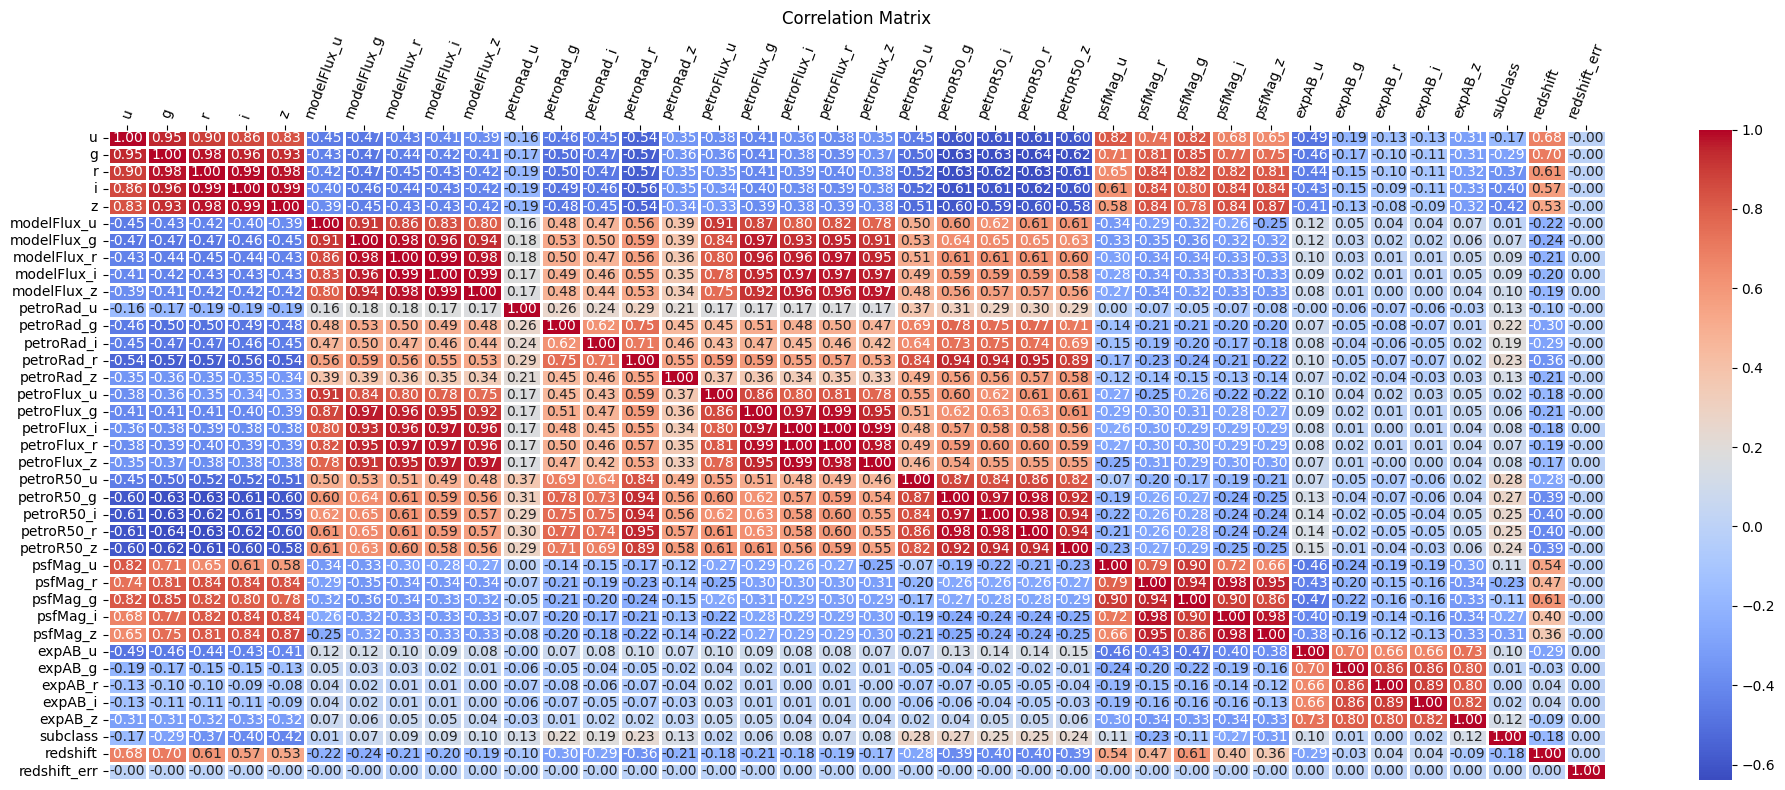

In [ ]:
corr_mat = df.drop('class', axis = 1).corr()

plt.figure(figsize = (20, 8))
sns.heatmap(corr_mat, annot = True, linewidths = 1, linecolor = 'white', cmap = 'coolwarm', fmt = '.2f')
plt.gca().tick_params(axis = 'x', rotation = 70, labelsize = 10)
plt.gca().tick_params(axis = 'y', labelsize = 10)
plt.gca().xaxis.set_ticks_position('top')

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
selected_features = corr_mat['subclass'][abs(corr_mat['subclass']) > 0.26].index.tolist()
selected_features.remove('subclass')1
selected_features

['g', 'r', 'i', 'z', 'petroR50_u', 'petroR50_g', 'psfMag_i', 'psfMag_z']

In [ ]:
df[selected_features + ['subclass']]

g         r         i         z  petroR50_u  petroR50_g  \
0      20.26633  19.32409  18.64037  18.23833    1.984029    1.835038   
1      19.32016  18.67888  18.24693  18.04122    1.069268    1.278203   
2      21.19671  19.92297  19.31443  18.68396    0.663606    0.947109   
3      18.41520  17.47202  17.05297  16.72423    3.160263    2.093415   
5      18.18575  17.52763  17.14837  16.89580    2.455249    2.130651   
...         ...       ...       ...       ...         ...         ...   
99995  18.25375  17.28985  16.82903  16.43054    2.844887    2.000412   
99996  20.82547  19.02462  18.43225  17.96795    2.066347    1.543782   
99997  18.14944  17.45517  17.04435  16.77127    3.321299    2.630662   
99998  18.17619  17.53119  17.05532  16.85166    1.041669    1.374057   
99999  20.12450  19.96307  19.35898  19.51870    1.441615    1.337342   

       psfMag_i  psfMag_z  subclass  
0      20.07646  19.43575       1.0  
1      19.19277  18.85012       1.0  
2      20.00731  19.42235       1.0  
3      18.38868  18.03204       1.0  
5      18.44931  18.23220       1.0  
...         ...       ...       ...  
99995  18.36605  17.91477       1.0  
99996  19.84113  19.48296       1.0  
99997  19.11502  18.74449       1.0  
99998  18.01613  17.75661       1.0  
99999  20.22217  20.38782       0.0  

[97478 rows x 9 columns]

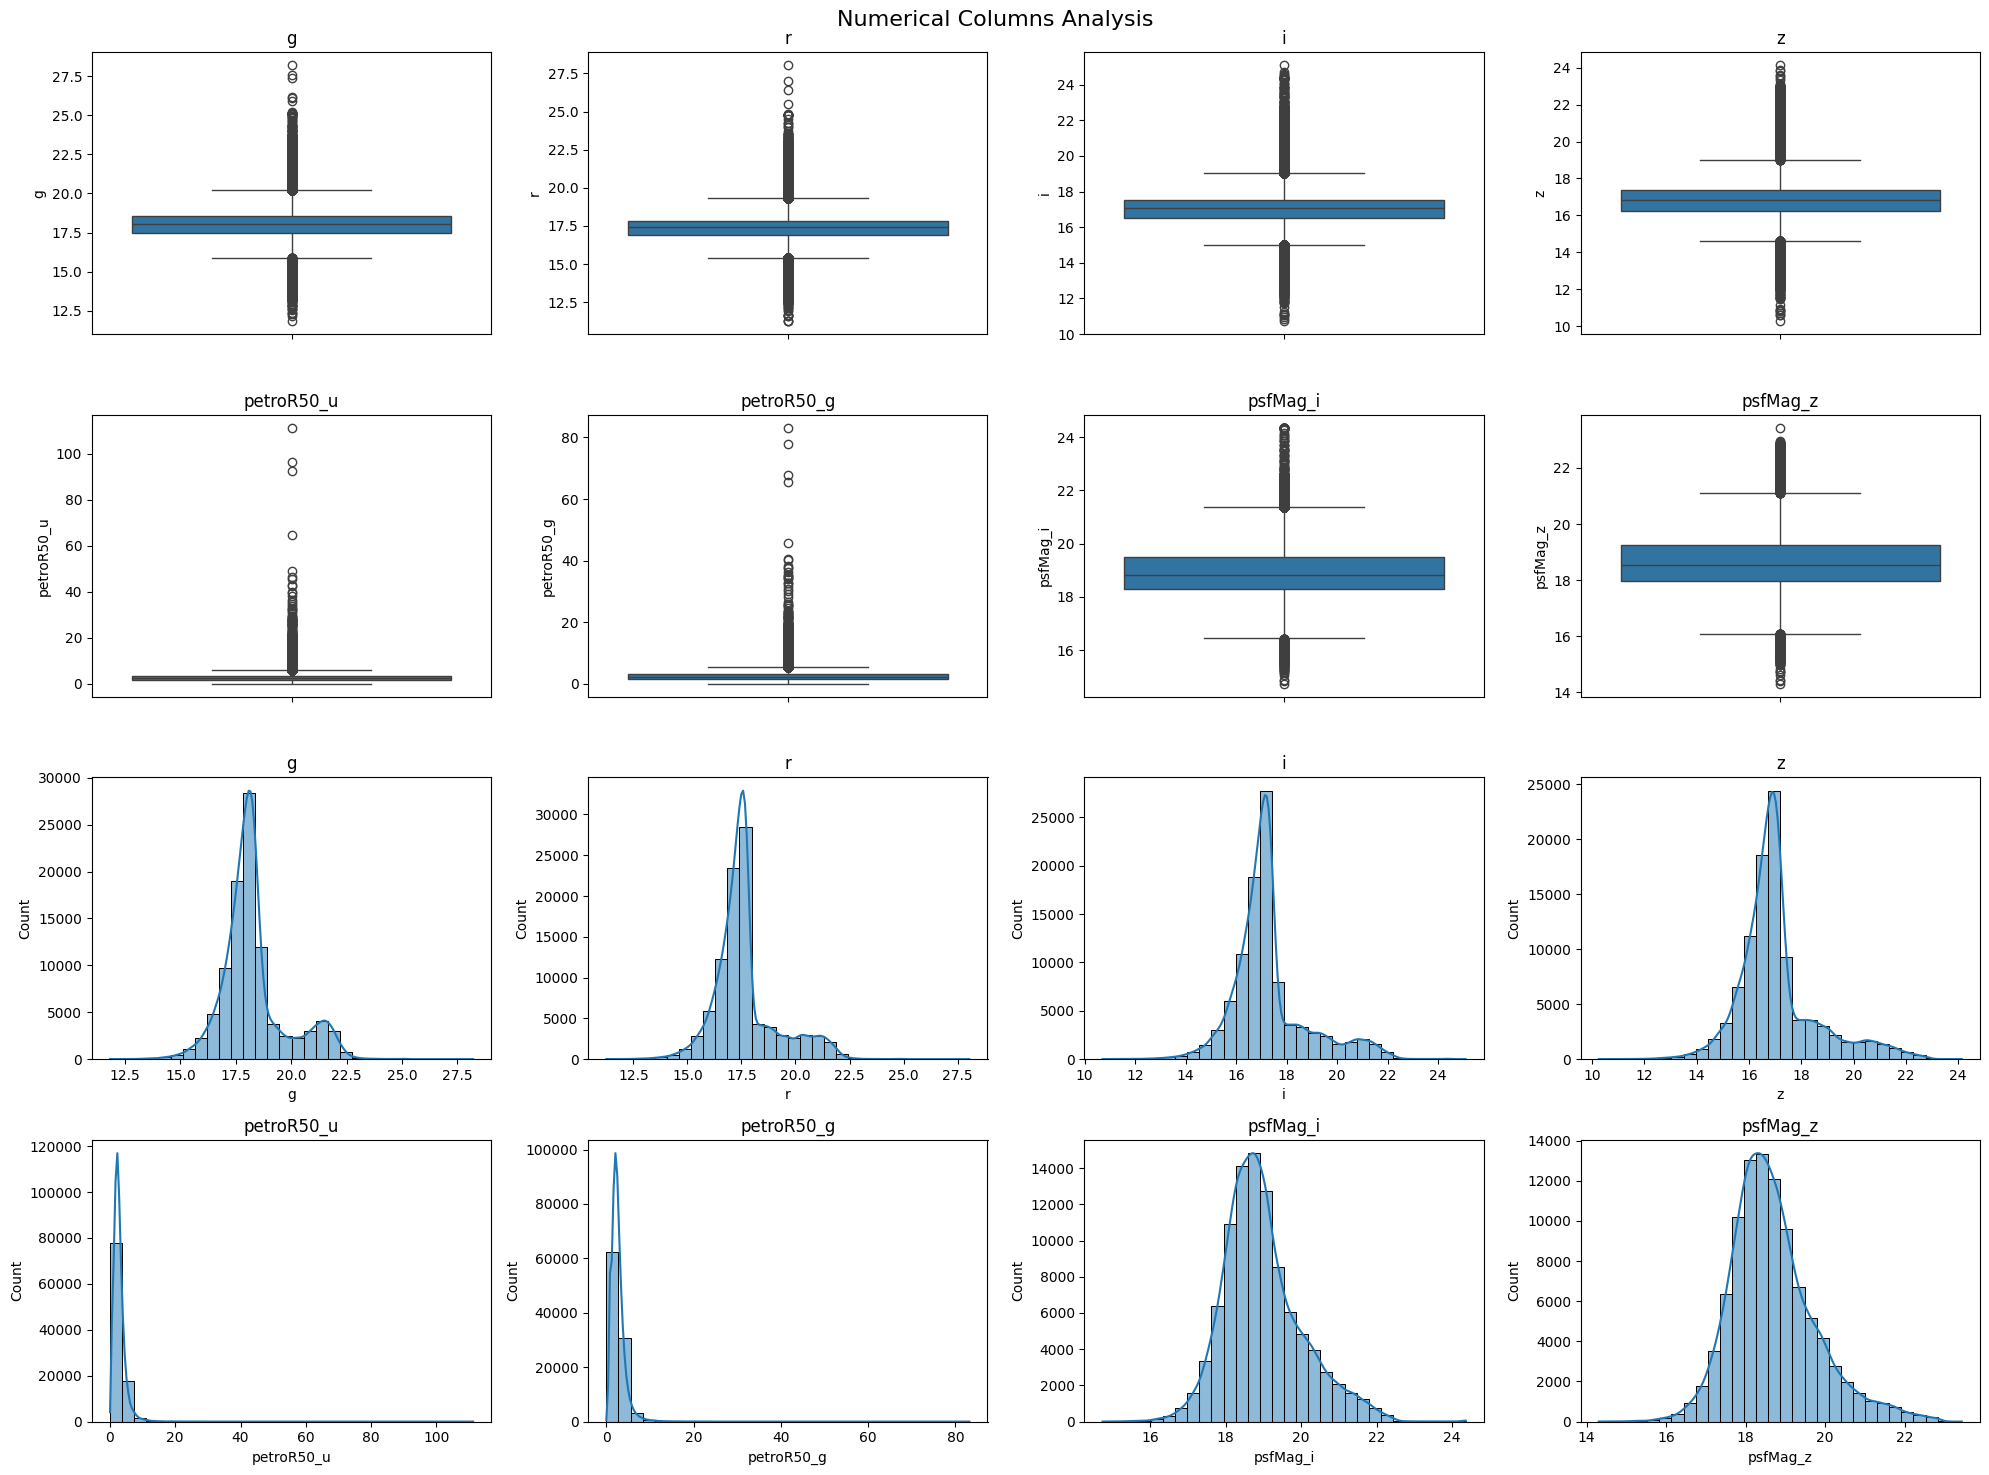

In [ ]:
def num_col_analysis(df, num_cols, n_rows, n_cols, title = None):
  plt.figure(figsize = (20, 15))

  i = 1
  for col in num_cols:
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(df[col])
    plt.title(col)
    i += 1

  for col in num_cols:
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], bins = 30, kde = True)
    plt.title(col)
    i += 1

  if title:
    plt.suptitle(title, fontsize=16)

  plt.tight_layout()
  plt.show()

num_col_analysis(df, selected_features, 4, 4, title = 'Numerical Columns Analysis')

In [ ]:
z_scores = np.abs(zscore(df[selected_features]))
mask = (z_scores < 2).all(axis=1)
df_clean = df[selected_features + ['subclass']][mask].reset_index(drop=True)

print("Shape after outlier removal:", df_clean.shape)

Shape after outlier removal: (83295, 9)


In [ ]:
df_clean.head()

g         r         i         z  petroR50_u  petroR50_g  psfMag_i  \
0  20.26633  19.32409  18.64037  18.23833    1.984029    1.835038  20.07646   
1  19.32016  18.67888  18.24693  18.04122    1.069268    1.278203  19.19277   
2  21.19671  19.92297  19.31443  18.68396    0.663606    0.947109  20.00731   
3  18.41520  17.47202  17.05297  16.72423    3.160263    2.093415  18.38868   
4  18.18575  17.52763  17.14837  16.89580    2.455249    2.130651  18.44931   

   psfMag_z  subclass  
0  19.43575       1.0  
1  18.85012       1.0  
2  19.42235       1.0  
3  18.03204       1.0  
4  18.23220       1.0

In [ ]:
df_clean.isnull().sum()

g             0
r             0
i             0
z             0
petroR50_u    0
petroR50_g    0
psfMag_i      0
psfMag_z      0
subclass      0
dtype: int64

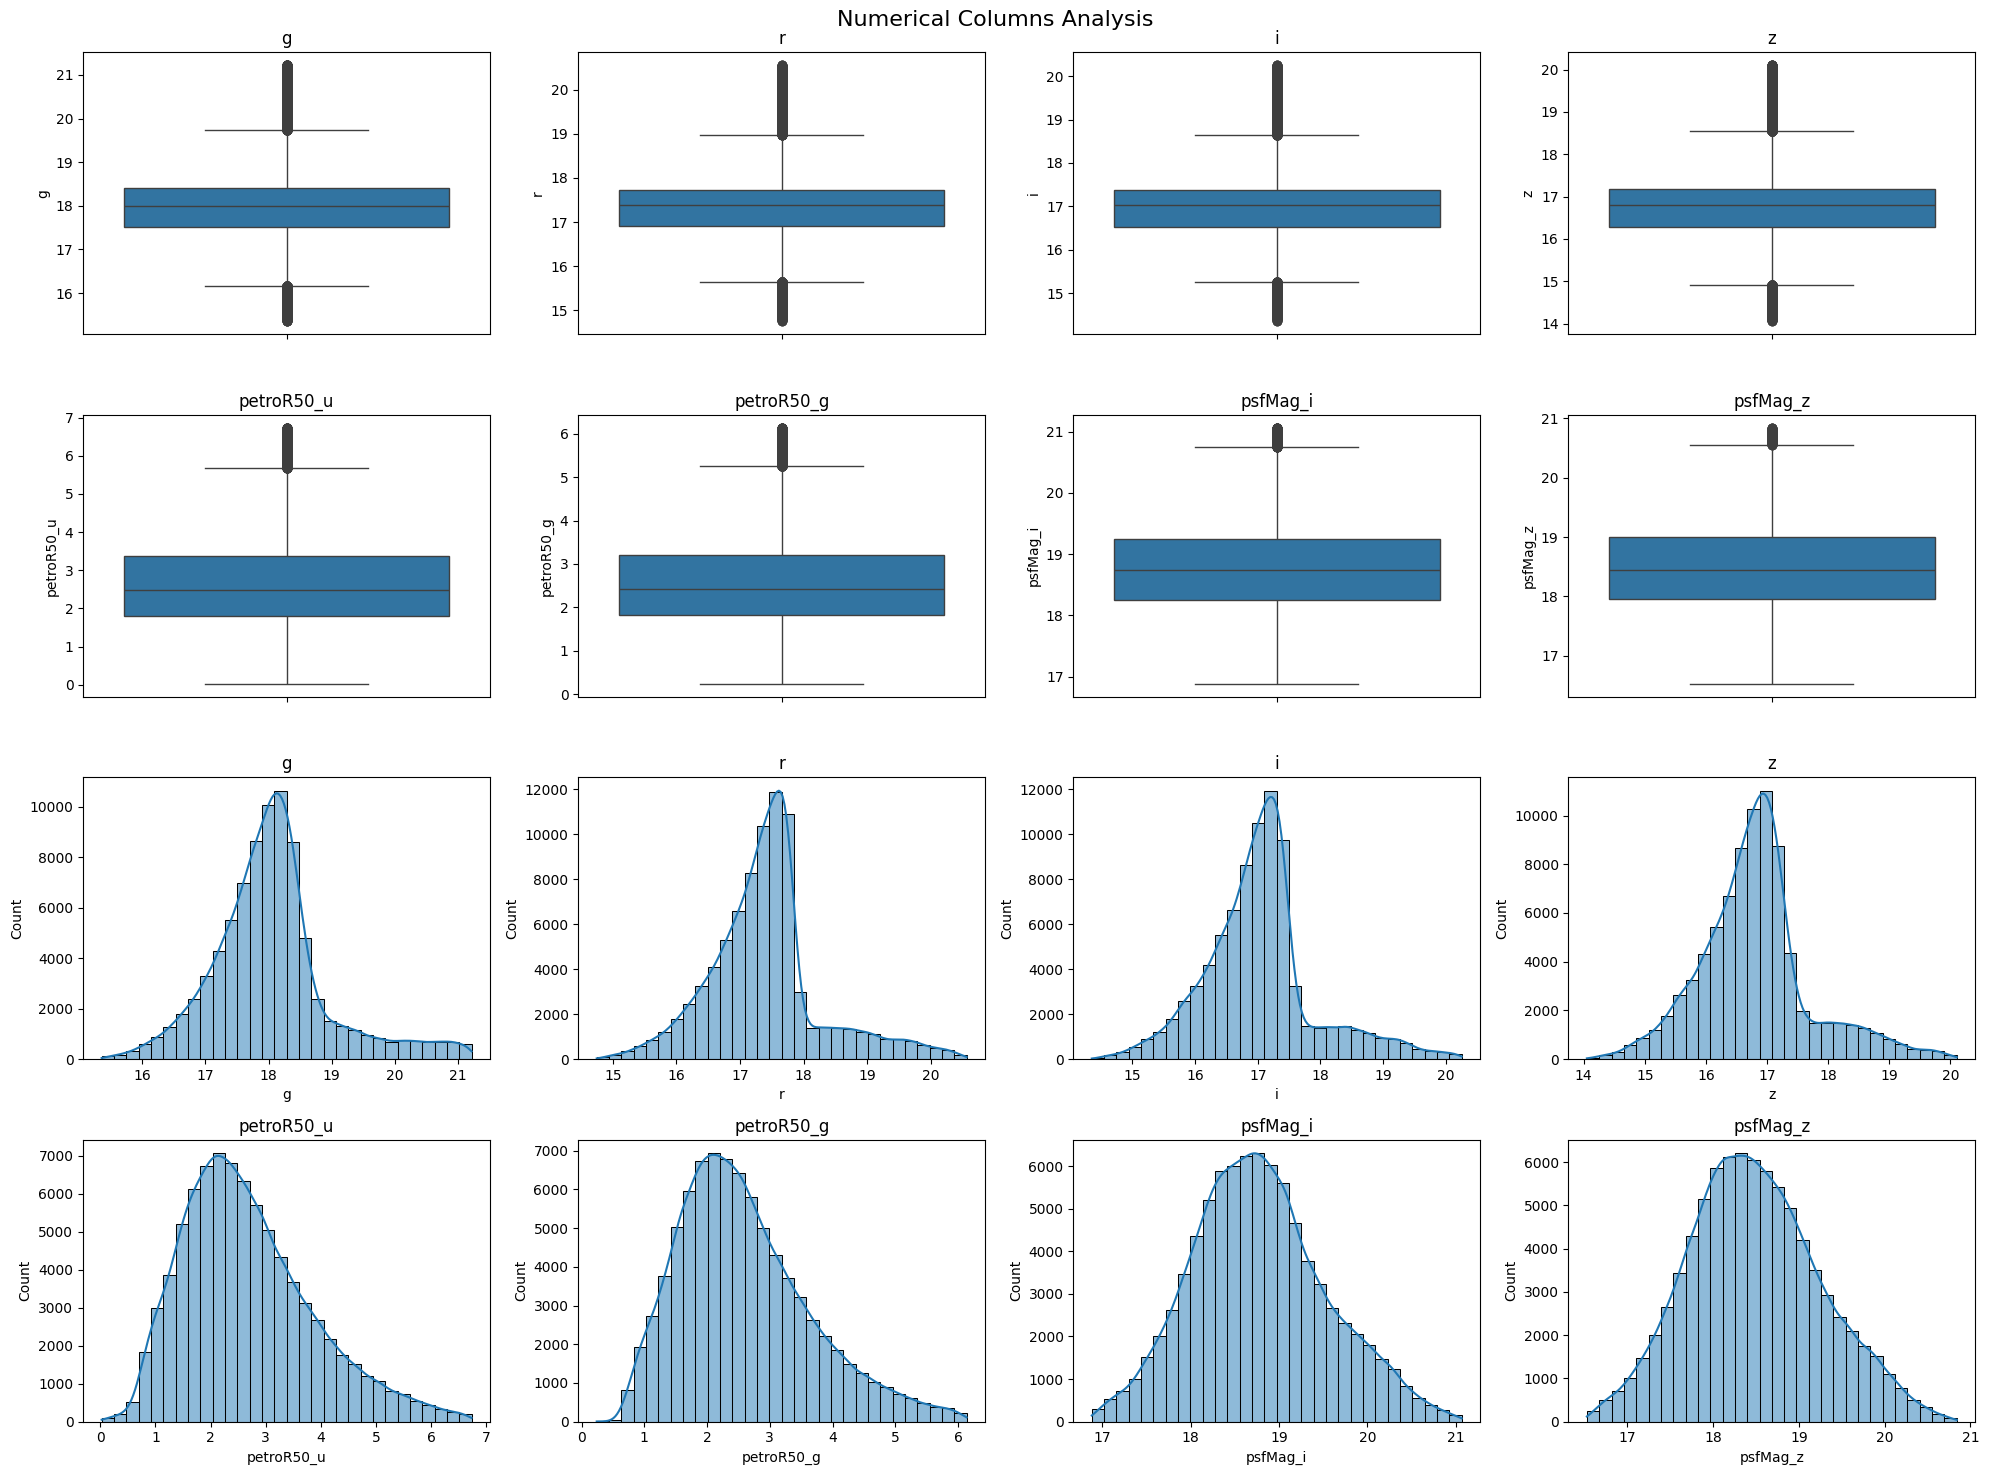

In [ ]:
num_col_analysis(df_clean, selected_features, 4, 4, title = 'Numerical Columns Analysis')

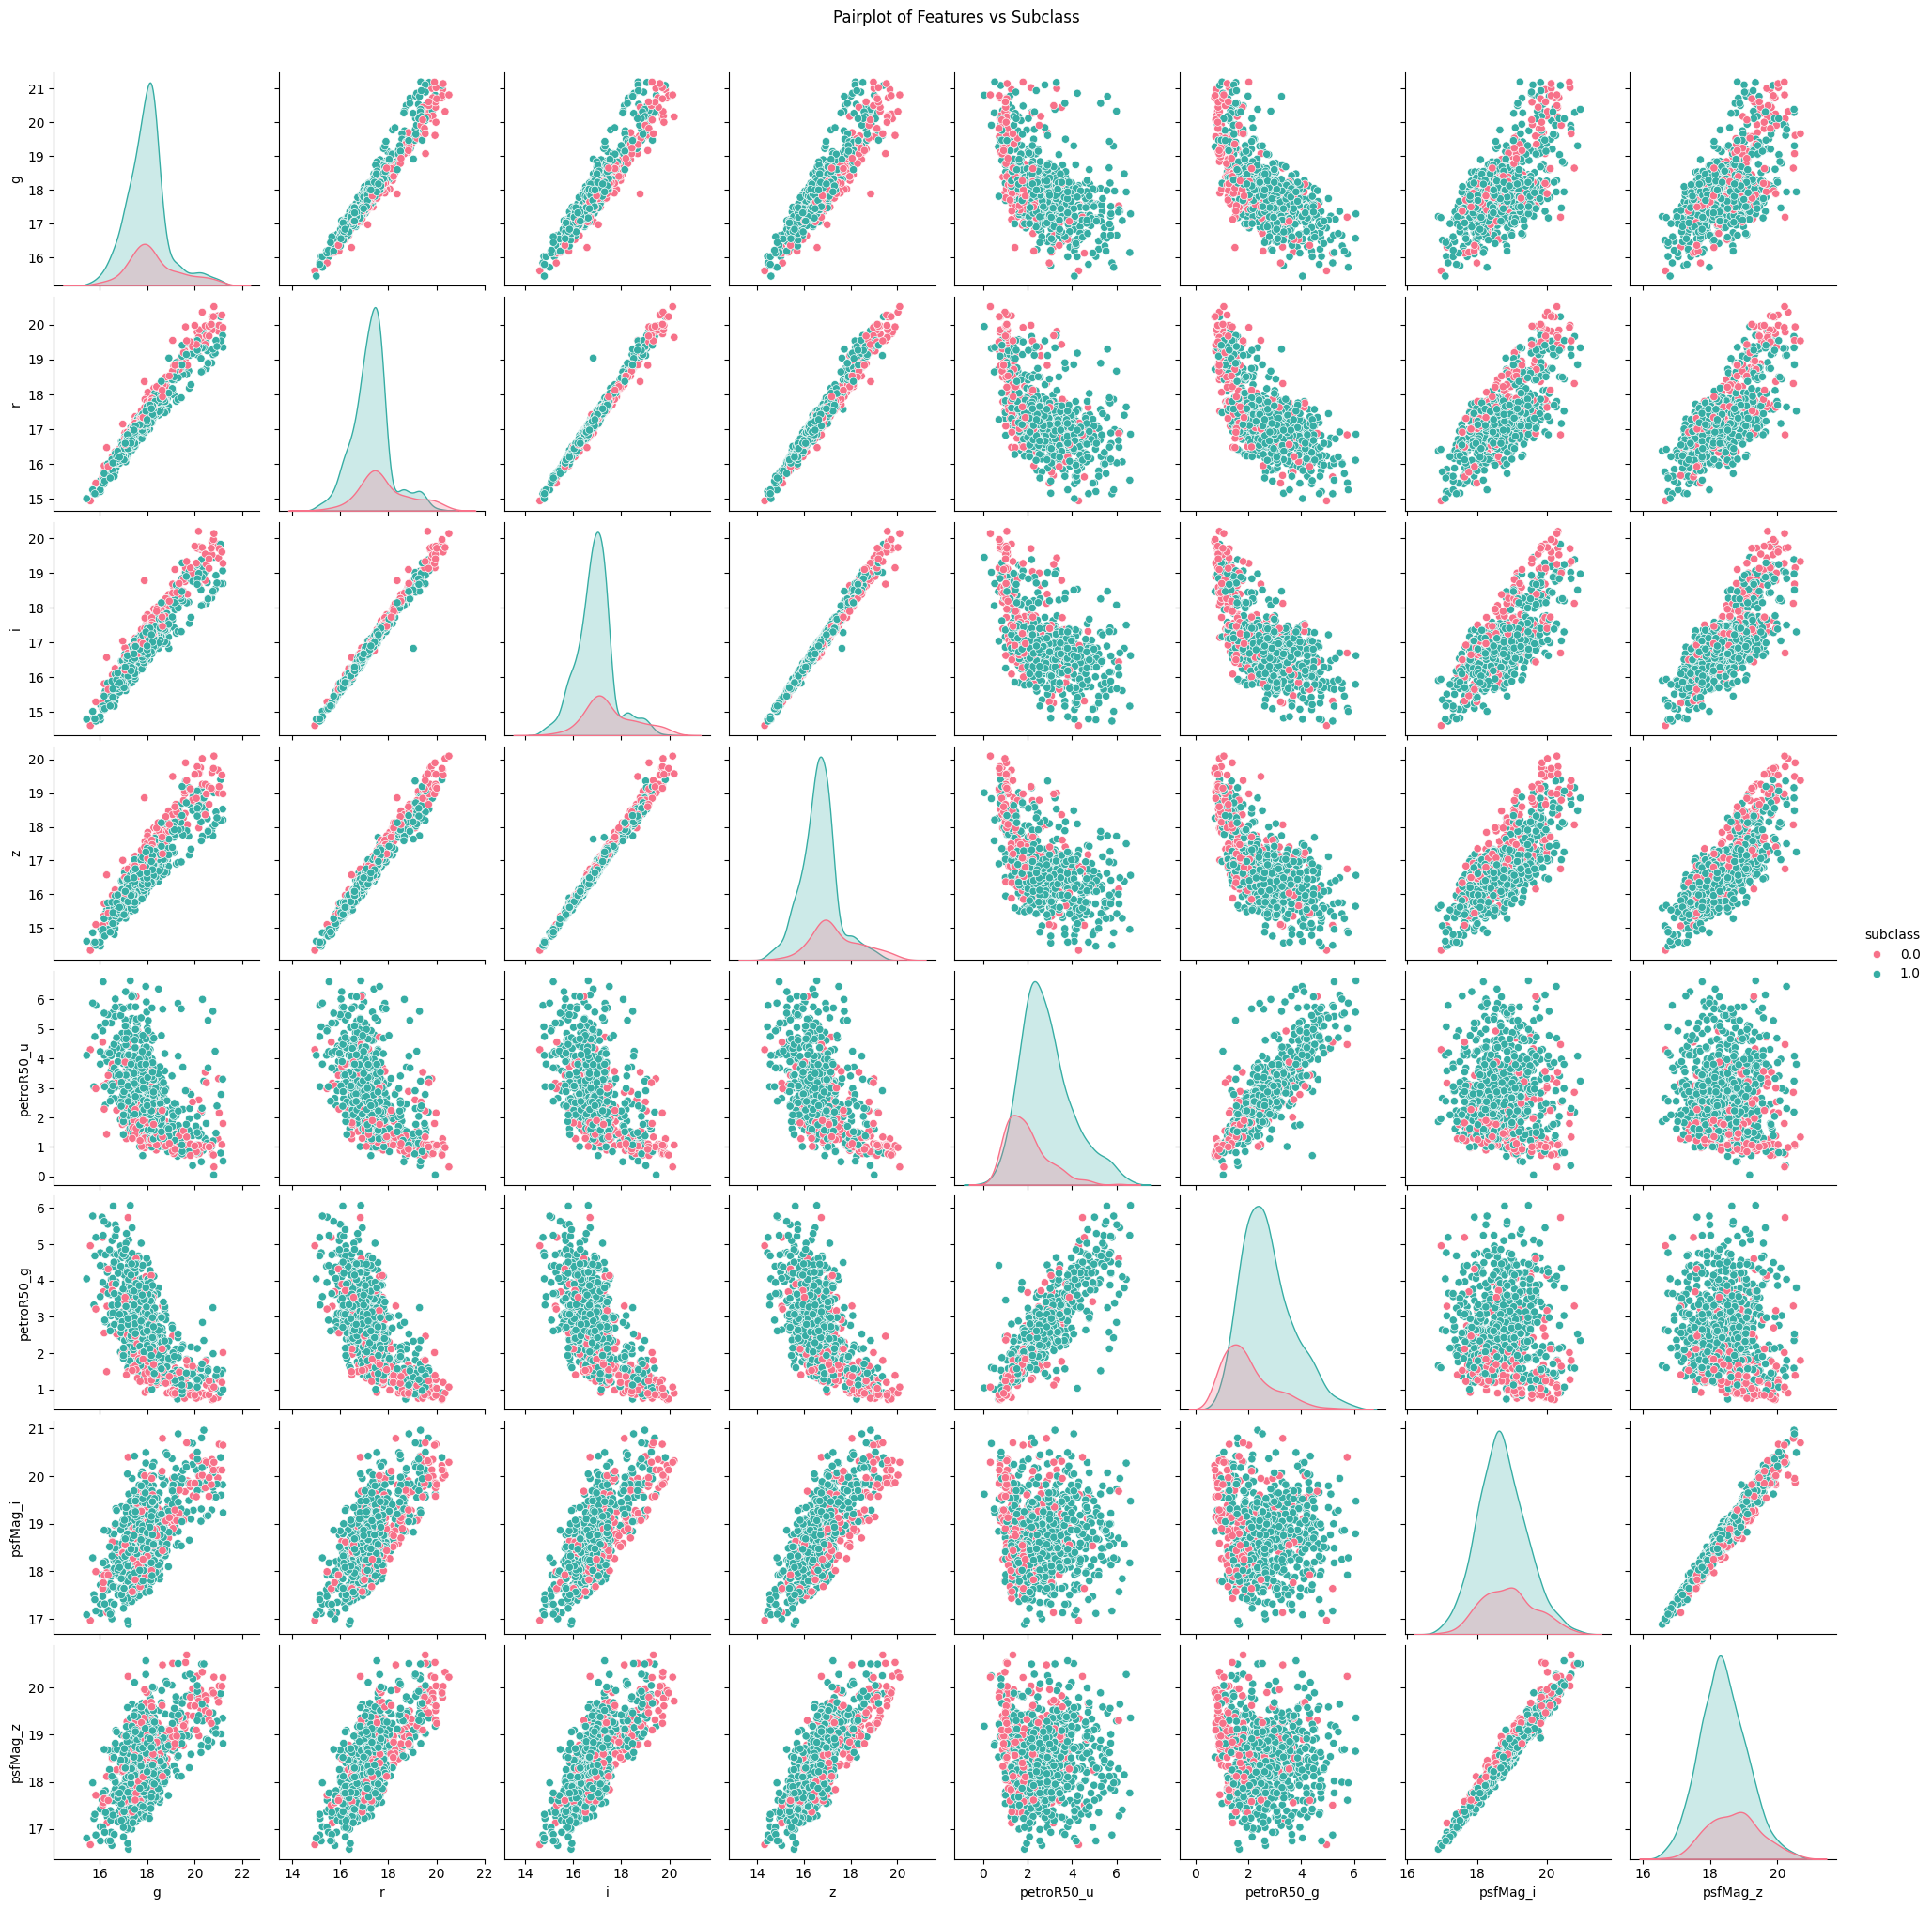

In [ ]:
subset = df_clean[selected_features + ['subclass']].sample(1000, random_state=42)
sns.pairplot(subset, hue='subclass', palette='husl')
plt.suptitle("Pairplot of Features vs Subclass", y=1.02)
plt.show()

In [ ]:
def feature_analysis(df):
  mi_score = mutual_info_classif(df.drop('subclass', axis = 1), df['subclass'])
  mi_imp = pd.DataFrame({'Feature' : df.drop('subclass', axis = 1).columns, 'Score' : mi_score}).sort_values(by = 'Score', ascending = False)

  rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
  rf_model.fit(df.drop('subclass', axis = 1), df['subclass'])
  rf_imp = pd.DataFrame({'Feature' : df.drop('subclass', axis = 1).columns, 'Score' : rf_model.feature_importances_}).sort_values(by = 'Score', ascending = False)

  return mi_imp, rf_imp

mi_imp, rf_imp = feature_analysis(df_clean)

In [ ]:
def plot_feature_imp(imp_df, x_col, title, pos):
  plt.subplot(1, 2, pos)
  sns.barplot(data = imp_df, x = x_col, y = 'Feature', hue = x_col, palette = 'Paired')
  plt.title(title)
  plt.tight_layout()

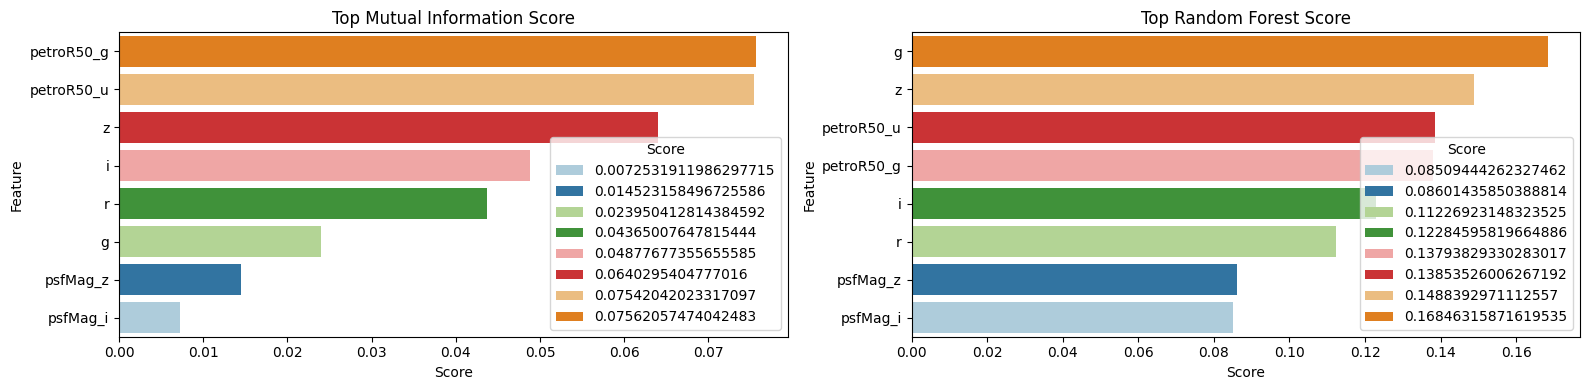

In [ ]:
plt.figure(figsize = (16, 4))
plot_feature_imp(mi_imp, 'Score', 'Top Mutual Information Score', 1)
plot_feature_imp(rf_imp, 'Score', 'Top Random Forest Score', 2)
plt.show()

In [ ]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df_clean.drop('subclass', axis = 1)), columns = selected_features, index = df_clean.index)
print(X_scaled.shape)
X_scaled.head()

(83295, 8)


g         r         i         z  petroR50_u  petroR50_g  psfMag_i  \
0  2.369885  2.148393  1.799546  1.555287   -0.585992   -0.721419  1.702699   
1  1.360401  1.425664  1.357899  1.340290   -1.357769   -1.250255  0.541272   
2  3.362521  2.819225  2.556197  2.041356   -1.700023   -1.564700  1.611816   
3  0.394885  0.073805  0.017647 -0.096211    0.406388   -0.476034 -0.515537   
4  0.150082  0.136096  0.124736  0.090928   -0.188427   -0.440671 -0.435851   

   psfMag_z  
0  1.227302  
1  0.469041  
2  1.209952  
3 -0.590190  
4 -0.331027

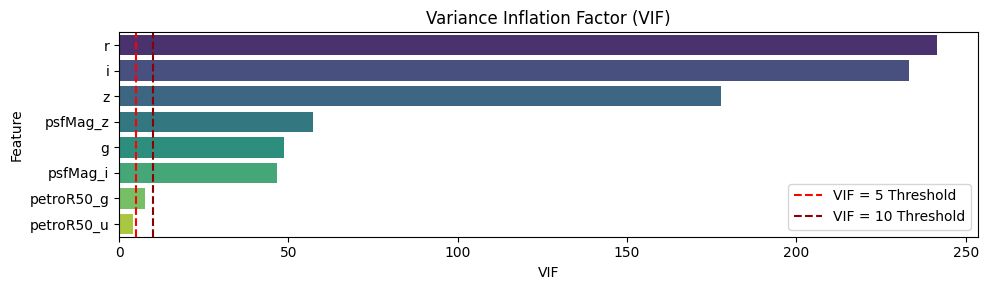


VIF Analysis Results:
Features with high multicollinearity (VIF > 10):
['r', 'i', 'z', 'psfMag_z', 'g', 'psfMag_i']
Features with moderate multicollinearity (5 < VIF < 10):
['petroR50_g']


In [ ]:
def analyze_vif(X, plot = True):
  vif_data = pd.DataFrame()
  vif_data['Feature'] = X.columns
  vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  vif_data = vif_data.sort_values(by = 'VIF', ascending = False)

  if plot:
    plt.figure(figsize = (10, 3))
    sns.barplot(data = vif_data, x = 'VIF', y = 'Feature', hue = 'Feature', palette = 'viridis')
    plt.title('Variance Inflation Factor (VIF)')
    plt.axvline(x = 5, color = 'red', linestyle = '--', label = 'VIF = 5 Threshold')
    plt.axvline(x = 10, color = 'darkred', linestyle = '--', label = 'VIF = 10 Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()

  print("\nVIF Analysis Results:")
  print("Features with high multicollinearity (VIF > 10):")
  print(vif_data[vif_data['VIF'] > 10]['Feature'].tolist())
  print("Features with moderate multicollinearity (5 < VIF < 10):")
  print(vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]['Feature'].tolist())

  return vif_data

vif_data = analyze_vif(X_scaled)

Starforming galaxies: 78.98%
Burst galaxies: 21.02%


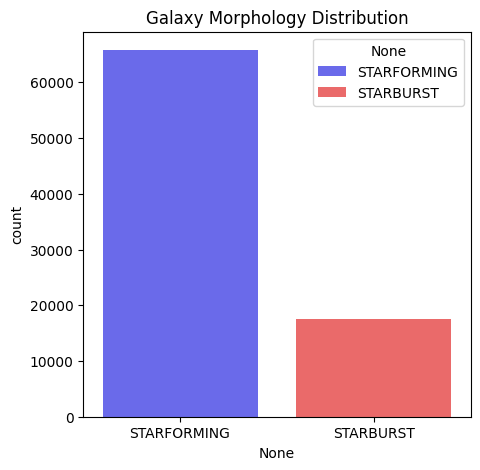

In [ ]:
subclass_labels = encoder.inverse_transform(df_clean[['subclass']])
label_series = pd.Series(subclass_labels.flatten())

plt.figure(figsize=(5,5))
sns.countplot(data=df_clean, x=label_series, hue = label_series, palette='seismic', legend = True)
plt.title("Galaxy Morphology Distribution")

dist = label_series.value_counts()
starform = int(dist['STARFORMING']) / len(label_series) * 100
burst = int(dist['STARBURST']) / len(label_series) * 100
print(f"Starforming galaxies: {starform:.2f}%")
print(f"Burst galaxies: {burst:.2f}%")
plt.show()

In [ ]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(df_clean.drop('subclass', axis = 1), df_clean['subclass'])
print(X_smote.shape)
print(y_smote.shape)

(131568, 8)
(131568,)


Starforming galaxies: 50.00%
Burst galaxies: 50.00%


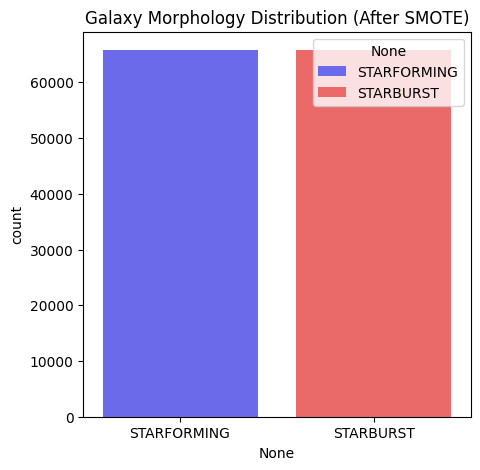

In [ ]:
y_smote_target = encoder.inverse_transform(y_smote.values.reshape(-1, 1))
smote_label_series = pd.Series(y_smote_target.flatten())

plt.figure(figsize=(5, 5))
sns.countplot(data=df_clean, x=smote_label_series, hue = smote_label_series, palette='seismic', legend = True)
plt.title("Galaxy Morphology Distribution (After SMOTE)")

dist = smote_label_series.value_counts()
starform = int(dist['STARFORMING']) / len(smote_label_series) * 100
burst = int(dist['STARBURST']) / len(smote_label_series) * 100
print(f"Starforming galaxies: {starform:.2f}%")
print(f"Burst galaxies: {burst:.2f}%")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105254, 8), (26314, 8), (105254,), (26314,))

In [ ]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((105254, 8), (26314, 8), (105254,), (26314,))

In [ ]:
X_test_scaled[1]

array([ 0.35066475, -0.02839413, -0.15373409, -0.26464461, -0.73423762,
       -0.68186996, -0.57276581, -0.70577818])

In [ ]:
y_test

95680     0.0
72555     1.0
19881     1.0
114064    0.0
61497     0.0
         ... 
106479    0.0
31123     0.0
114786    0.0
13163     1.0
3202      1.0
Name: subclass, Length: 26314, dtype: float64

In [ ]:
def plot_evaluation(y_test, y_pred_prob, y_pred, model_name = 'Model', non_calib_prob = None):
  print(classification_report(y_test, y_pred))

  fig, axes = plt.subplots(2, 2, figsize = (12, 8))

  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False, ax = axes[0,0])
  axes[0,0].set_title('Confusion Matrix')
  axes[0,0].set_xlabel('Predicted')
  axes[0,0].set_ylabel('Actual')

  fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
  roc_auc = roc_auc_score(y_test, y_pred_prob)

  axes[0,1].plot(fpr, tpr, label = f'AUC : {roc_auc:.4f}')
  axes[0,1].plot([0,1], [0,1], 'k--')
  axes[0,1].set_xlabel('False Positive Rate')
  axes[0,1].set_ylabel('True Positive Rate')
  axes[0,1].set_title('ROC Curve')
  axes[0,1].legend()

  precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
  average_precision = average_precision_score(y_test, y_pred_prob)

  axes[1,0].plot(recall, precision, label = f'Average Precision : {average_precision:.4f}')
  axes[1,0].set_xlabel('Recall')
  axes[1,0].set_ylabel('Precision')
  axes[1,0].set_title('Precision-Recall Curve')
  axes[1,0].legend()

  if non_calib_prob is not None:
    true_prob_cal, pred_prob_cal = calibration_curve(y_test, non_calib_prob, n_bins = 10)
    axes[1,1].plot(pred_prob_cal, true_prob_cal, marker = 'o', label = 'Not Calibrated', color = 'gray')

  prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins = 10)
  axes[1, 1].plot(prob_pred, prob_true, marker = 'o', label = model_name)
  axes[1, 1].plot([0, 1], [0, 1], 'k--', label = 'Perfect Calibration')
  axes[1, 1].set_xlabel('Predicted Probability')
  axes[1, 1].set_ylabel('Actual Probability')
  axes[1, 1].set_title('Calibration Curve')
  axes[1, 1].legend()

  plt.tight_layout()
  plt.show()

  return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_prob),
        'avg_precision': average_precision_score(y_test, y_pred_prob)
    }

In [ ]:
def objective_dt(trial):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    model = DecisionTreeClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

In [ ]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective_dt, n_trials=10)

print("Best Decision Tree Parameters:")
best_params_dt = study_dt.best_params
for key, value in best_params_dt.items():
    print(f"{key}: {value}")

[I 2025-07-14 01:36:37,751] A new study created in memory with name: no-name-753ad16a-81f9-46ae-ba01-6dcda1ff0b20
[I 2025-07-14 01:36:43,964] Trial 0 finished with value: 0.8537050911258776 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.8537050911258776.
[I 2025-07-14 01:36:54,762] Trial 1 finished with value: 0.8603410363603906 and parameters: {'criterion': 'entropy', 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.8603410363603906.
[I 2025-07-14 01:36:56,968] Trial 2 finished with value: 0.8408447560506149 and parameters: {'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8603410363603906.
[I 2025-07-14 01:37:00,205] Trial 3 finished with value: 0.856485595236822 and parameters: {'criterion': 'gini', 'max_depth': 15,

Best Decision Tree Parameters:
criterion: entropy
max_depth: 10
min_samples_split: 10
min_samples_leaf: 3
max_features: None


              precision    recall  f1-score   support

         0.0       0.81      0.82      0.82     13157
         1.0       0.82      0.81      0.82     13157

    accuracy                           0.82     26314
   macro avg       0.82      0.82      0.82     26314
weighted avg       0.82      0.82      0.82     26314



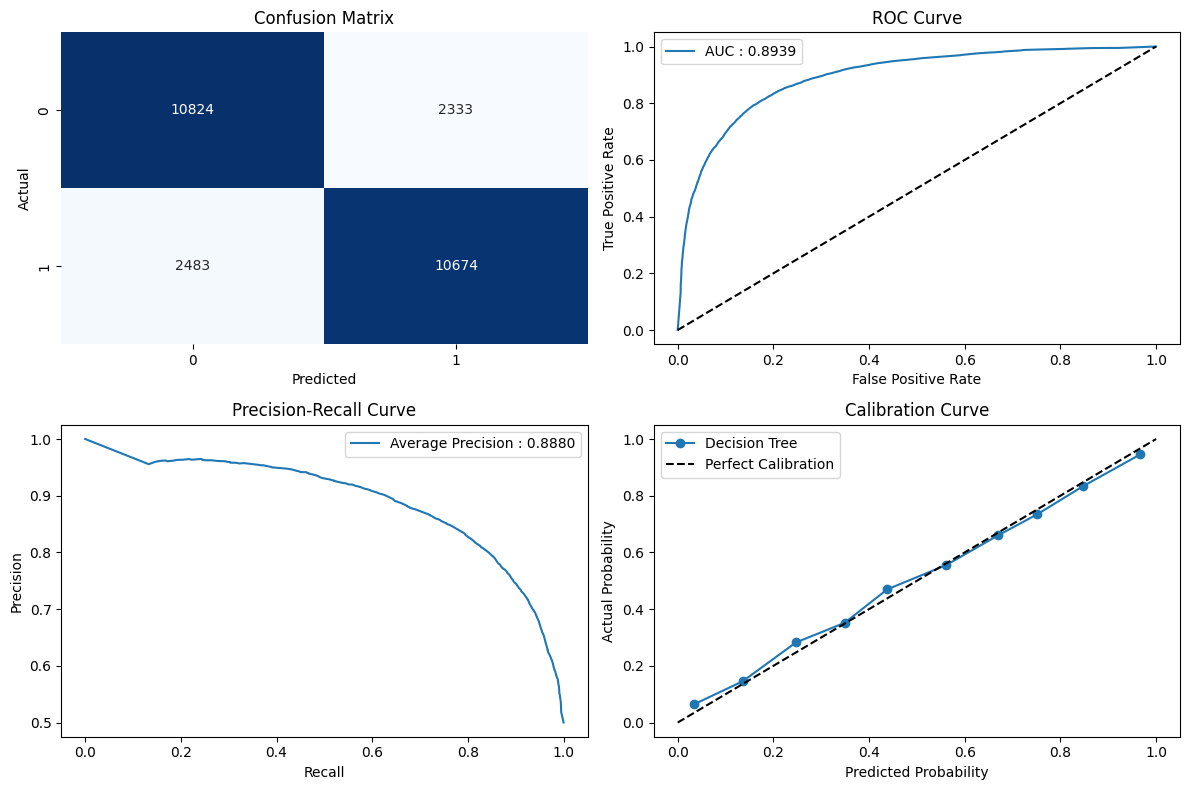

In [ ]:
dtc_model = DecisionTreeClassifier(**best_params_dt, random_state=42)
dtc_model.fit(X_train_scaled, y_train)

dtc_metrics = plot_evaluation(y_test, dtc_model.predict_proba(X_test_scaled)[:,1], y_pred = dtc_model.predict(X_test_scaled), model_name = 'Decision Tree')

              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81     13157
         1.0       0.81      0.81      0.81     13157

    accuracy                           0.81     26314
   macro avg       0.81      0.81      0.81     26314
weighted avg       0.81      0.81      0.81     26314



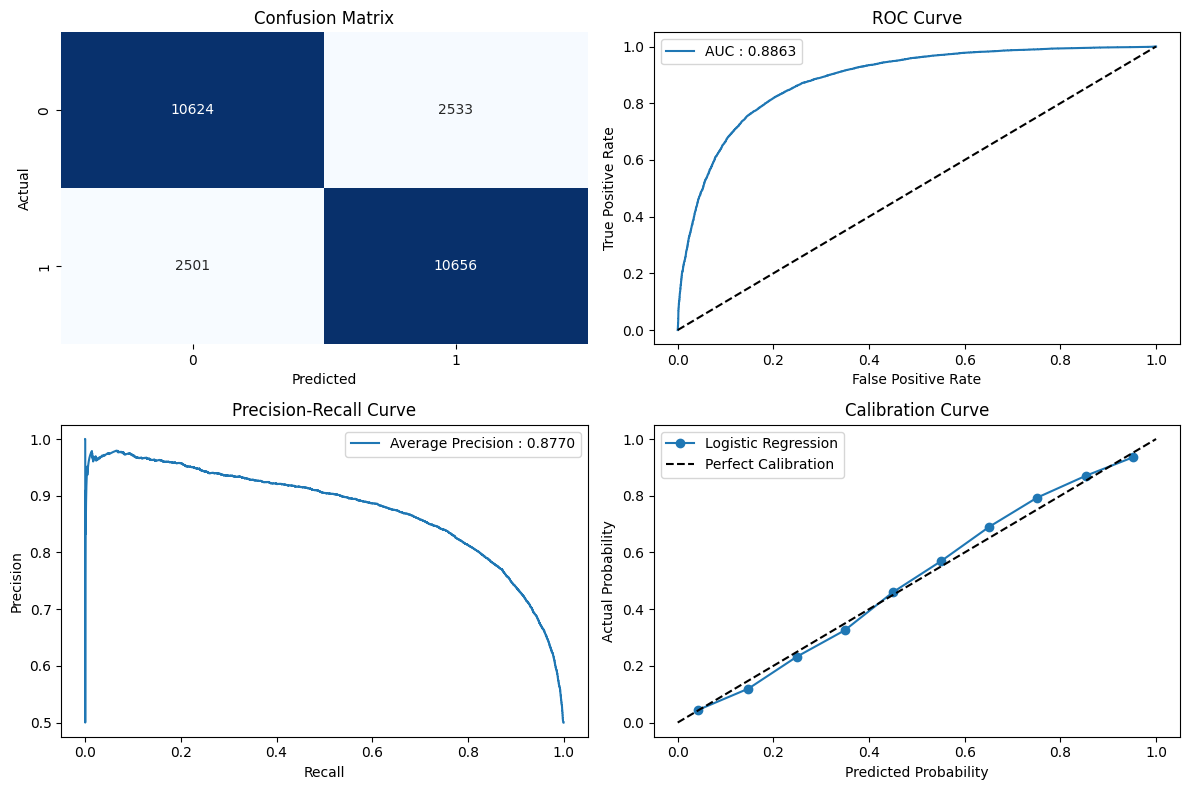

In [ ]:
lr_model = LogisticRegression(max_iter = 5000 ,random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_metrics = plot_evaluation(y_test, lr_model.predict_proba(X_test_scaled)[:,1], y_pred = lr_model.predict(X_test_scaled), model_name = 'Logistic Regression')

In [ ]:
def objective_rf(trial):
  params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    }

  model = RandomForestClassifier(**params, random_state = 42)
  scores = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring = 'roc_auc')
  return scores.mean()

In [ ]:
study_rf = optuna.create_study(direction = 'maximize')
study_rf.optimize(objective_rf, n_trials = 20)

print("Best Random Forest Parameters:")
best_params_rf = study_rf.best_params
for key, value in best_params_rf.items():
    print(f"{key}: {value}")

In [ ]:
best_params_rf = {'n_estimators': 56, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 2, 'criterion': 'entropy'}

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87     13157
         1.0       0.87      0.85      0.86     13157

    accuracy                           0.86     26314
   macro avg       0.86      0.86      0.86     26314
weighted avg       0.86      0.86      0.86     26314



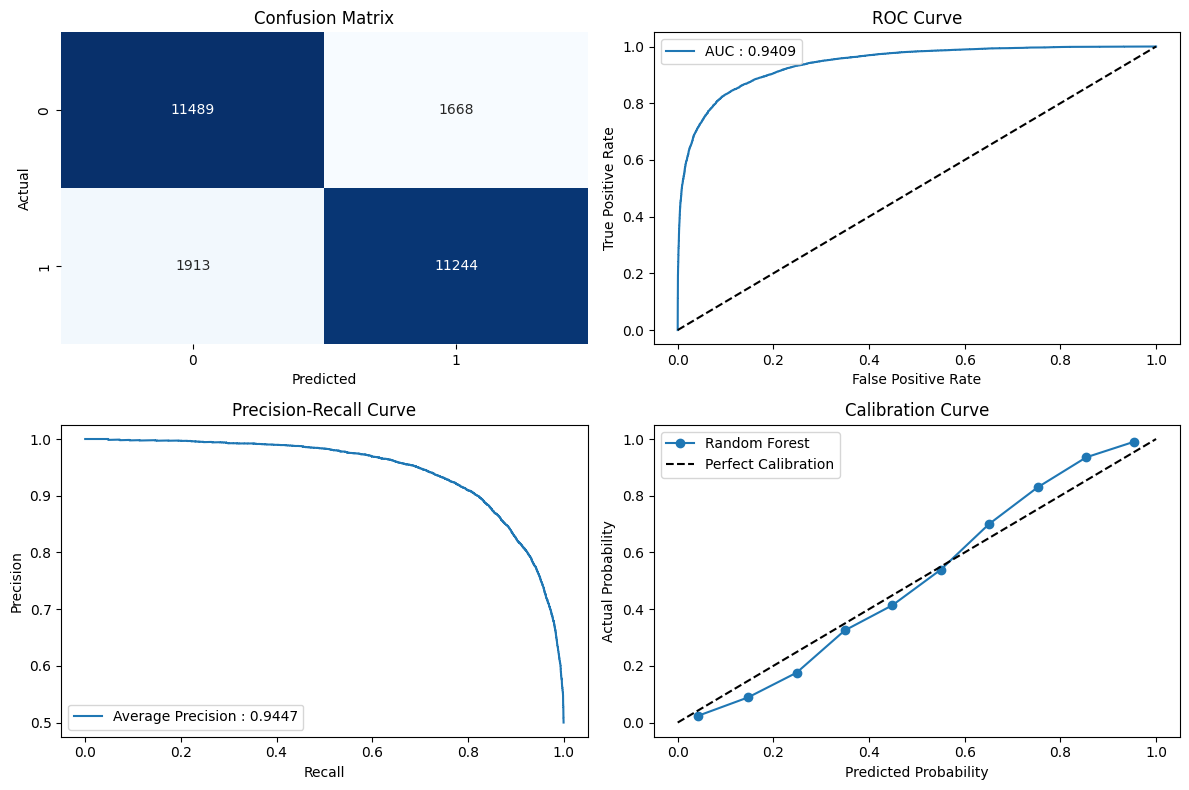

In [ ]:
rf_model = RandomForestClassifier(**best_params_rf, random_state = 42)
rf_model.fit(X_train_scaled, y_train)
rf_metrics = plot_evaluation(y_test, rf_model.predict_proba(X_test_scaled)[:,1], y_pred = rf_model.predict(X_test_scaled), model_name = 'Random Forest')

In [ ]:
model_metrics = {
    'Random Forest': rf_metrics,
    'Logistic Regression': lr_metrics,
    'Decision Tree': dtc_metrics
}

metrics_df = pd.DataFrame(model_metrics).T

def highlight_max_min(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return [
        'font-weight: bold; color: lightgreen' if max_ else (
            'font-weight: bold; color: darkblue' if min_ else ''
        )
        for max_, min_ in zip(is_max, is_min)
    ]

styled_df = metrics_df.style.apply(highlight_max_min, subset=metrics_df.columns, axis=0)
print("\nModel Comparison:")
styled_df


Model Comparison:


<Figure size 1000x600 with 0 Axes>

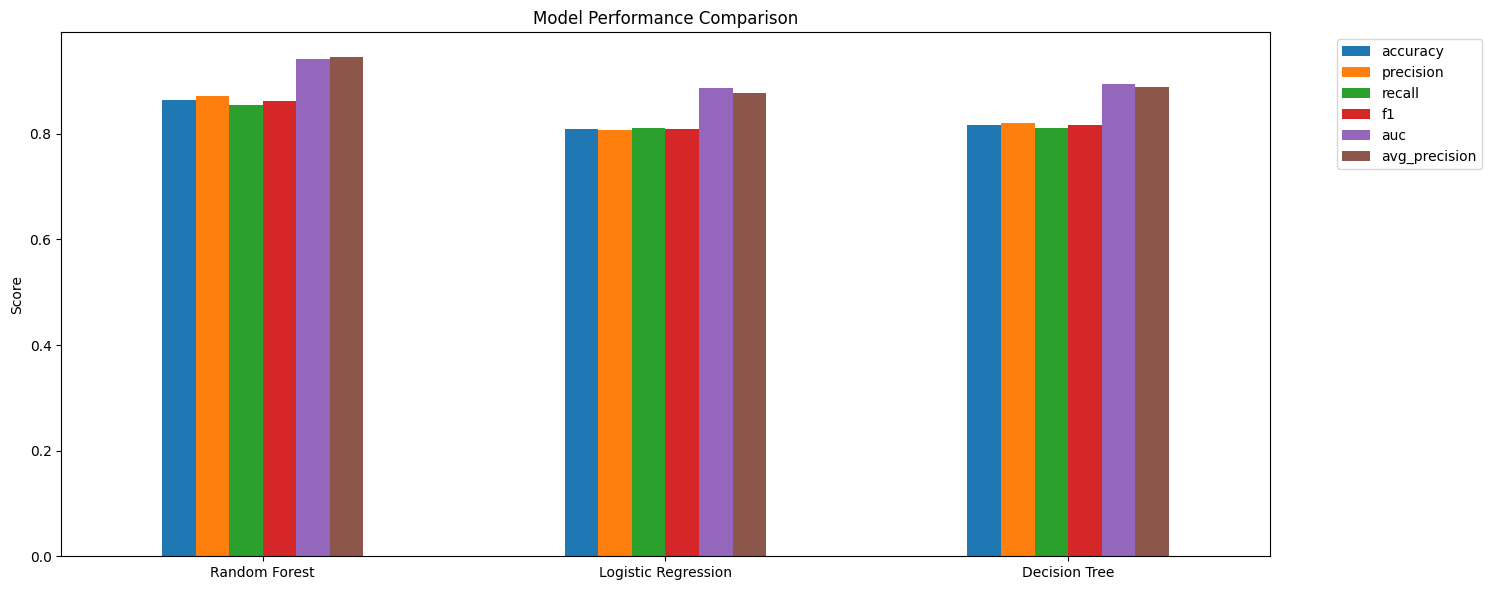

In [ ]:
plt.figure(figsize = (10, 6))
metrics_df.plot(kind = 'bar', figsize = (15, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation = 0)
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()
plt.show()

In [ ]:
with open('best_param_dtc.pkl', 'wb') as f:
  pickle.dump(best_params_dt, f)

with open('best_param_rf.pkl', 'wb') as f:
  pickle.dump(best_params_rf, f)

In [ ]:
joblib.dump(dtc_model, 'dtc_model.joblib')
joblib.dump(rf_model, 'rf_model.joblib')
joblib.dump(lr_model, 'lr_model.joblib')

['lr_model.joblib']

In [ ]:
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']

In [ ]:
selected_features

['g', 'r', 'i', 'z', 'petroR50_u', 'petroR50_g', 'psfMag_i', 'psfMag_z']

<h2>Scenario 2</>

In [ ]:
selected_features_sc2 = corr_mat['redshift'][abs(corr_mat['redshift']) > 0.40].index.tolist()
selected_features_sc2.remove('redshift')
len(selected_features_sc2)

10

In [ ]:
df[selected_features_sc2 + ['redshift']].head()

u         g         r         i         z  petroR50_i  petroR50_r  \
0  21.73818  20.26633  19.32409  18.64037  18.23833    1.438609    1.638081   
1  20.66761  19.32016  18.67888  18.24693  18.04122    1.284687    1.263937   
2  23.63531  21.19671  19.92297  19.31443  18.68396    0.995734    0.987395   
3  20.12374  18.41520  17.47202  17.05297  16.72423    2.023142    2.156205   
5  19.47473  18.18575  17.52763  17.14837  16.89580    1.937913    1.983631   

   psfMag_u  psfMag_r  psfMag_g  redshift  
0  22.58631  20.75200  21.66492  0.067749  
1  21.31284  19.67125  20.23801  0.105118  
2  23.92244  20.66160  21.83267  0.234089  
3  21.34938  18.77640  19.75832  0.110825  
5  20.71206  18.92355  19.66453  0.111458

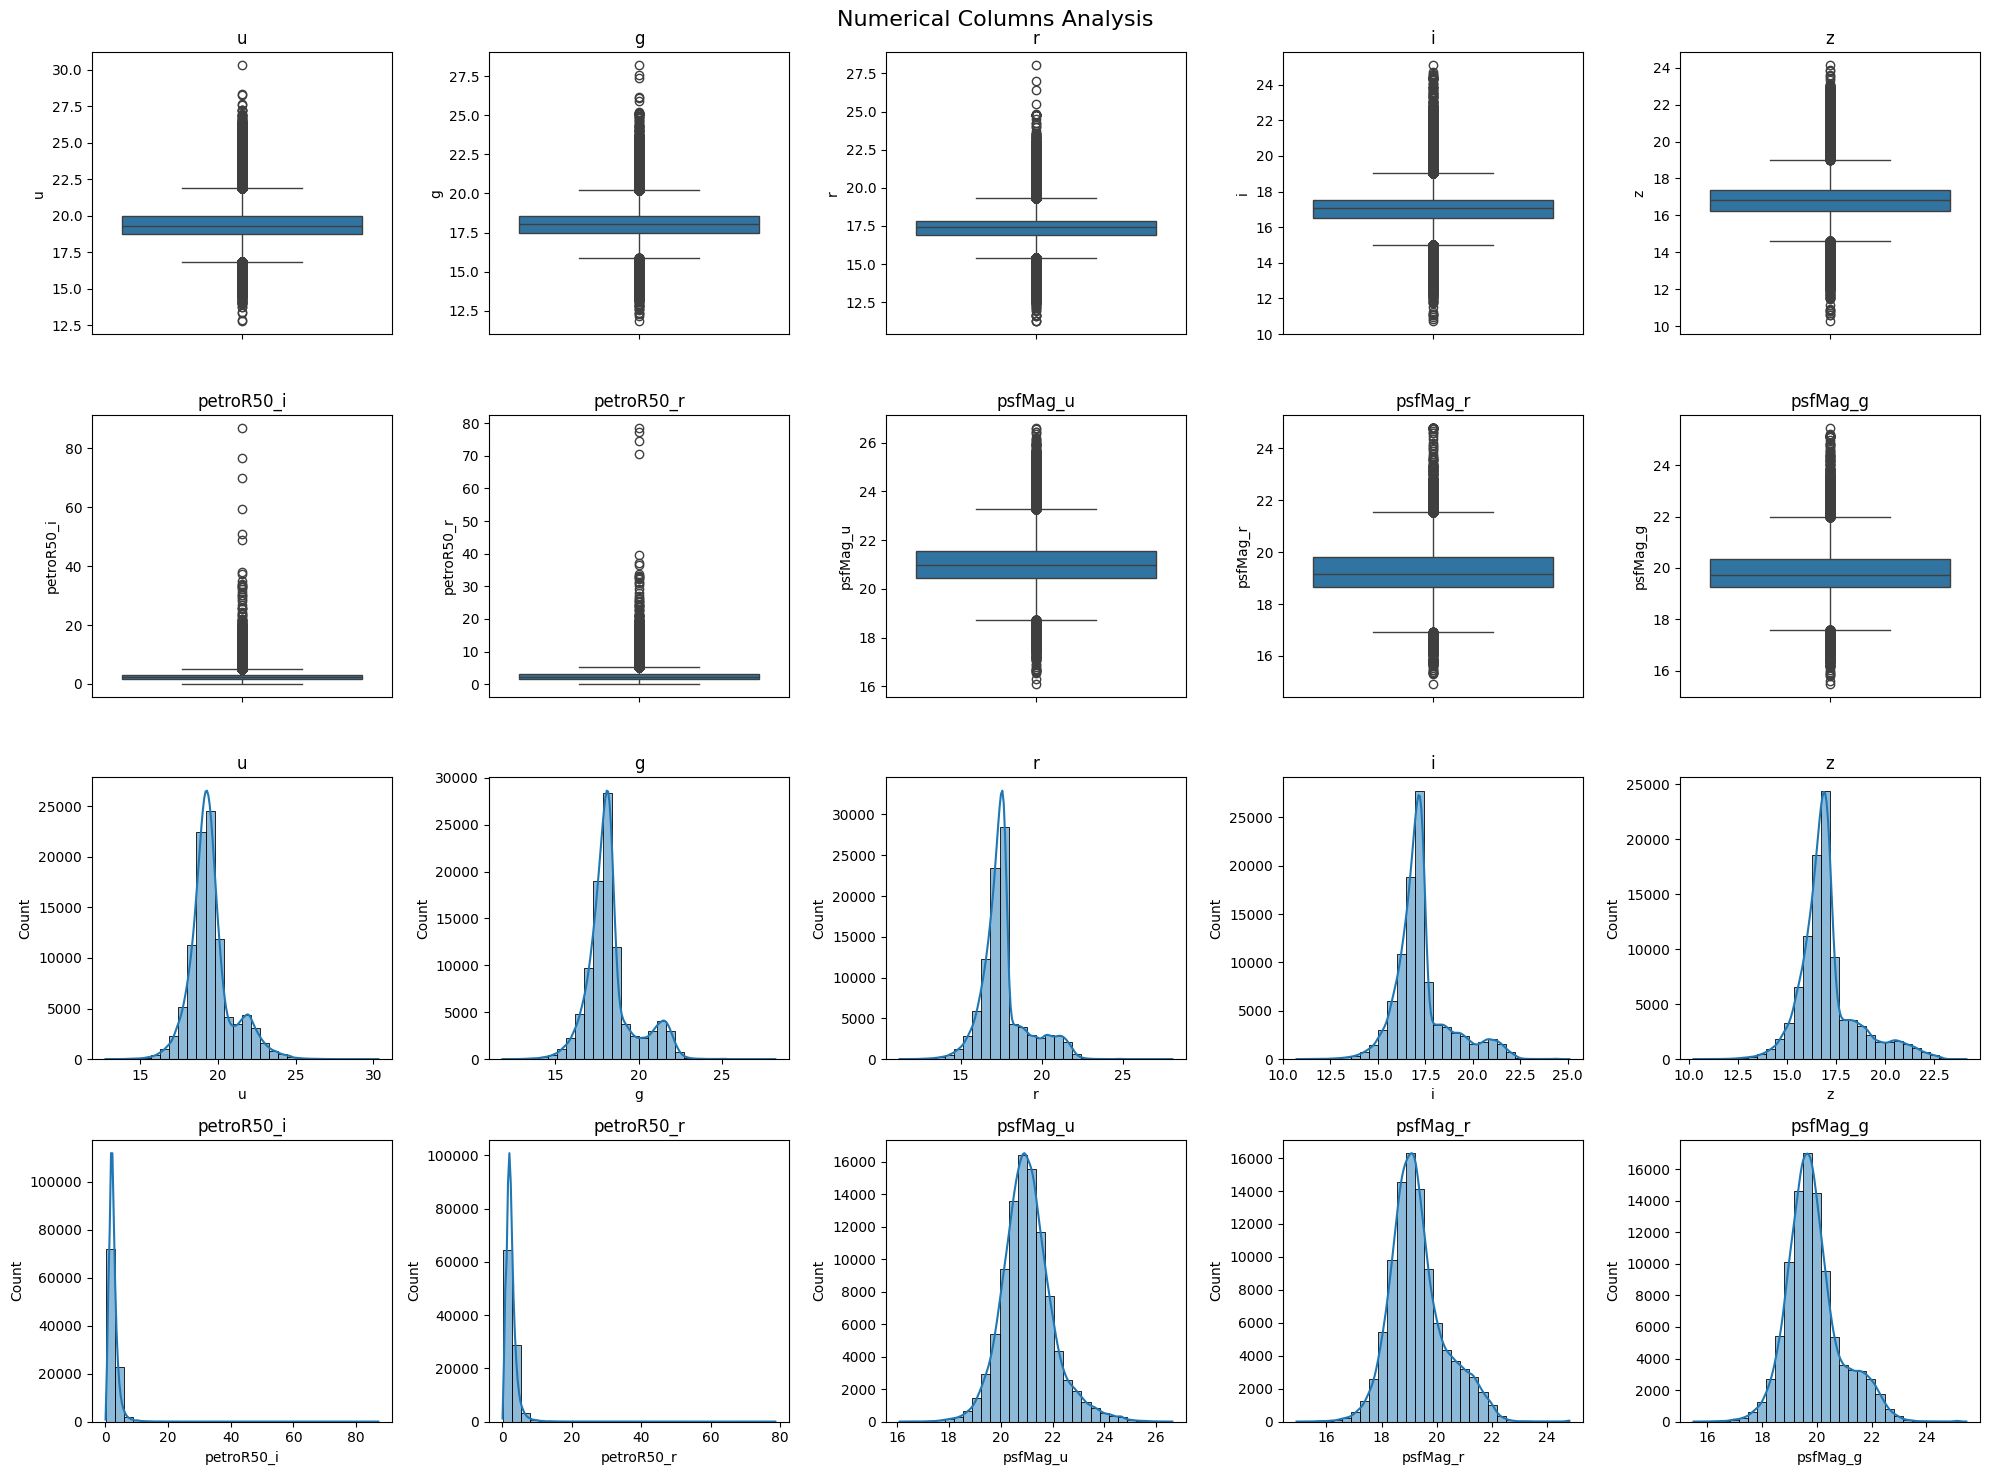

In [ ]:
num_col_analysis(df, selected_features_sc2, 4, 5, title = 'Numerical Columns Analysis')

In [ ]:
z_scores = np.abs(zscore(df[selected_features_sc2]))
mask = (z_scores < 2).all(axis=1)
df_clean_sc2 = df[selected_features_sc2 + ['redshift']][mask].reset_index(drop=True)

print("Shape after outlier removal:", df_clean_sc2.shape)

Shape after outlier removal: (81506, 11)


In [ ]:
df_clean_sc2.head()

u         g         r         i         z  petroR50_i  petroR50_r  \
0  21.73818  20.26633  19.32409  18.64037  18.23833    1.438609    1.638081   
1  20.66761  19.32016  18.67888  18.24693  18.04122    1.284687    1.263937   
2  20.12374  18.41520  17.47202  17.05297  16.72423    2.023142    2.156205   
3  19.47473  18.18575  17.52763  17.14837  16.89580    1.937913    1.983631   
4  20.24418  18.62780  17.76331  17.26417  16.97725    1.862745    1.897097   

   psfMag_u  psfMag_r  psfMag_g  redshift  
0  22.58631  20.75200  21.66492  0.067749  
1  21.31284  19.67125  20.23801  0.105118  
2  21.34938  18.77640  19.75832  0.110825  
3  20.71206  18.92355  19.66453  0.111458  
4  21.35114  18.94229  19.80561  0.112151

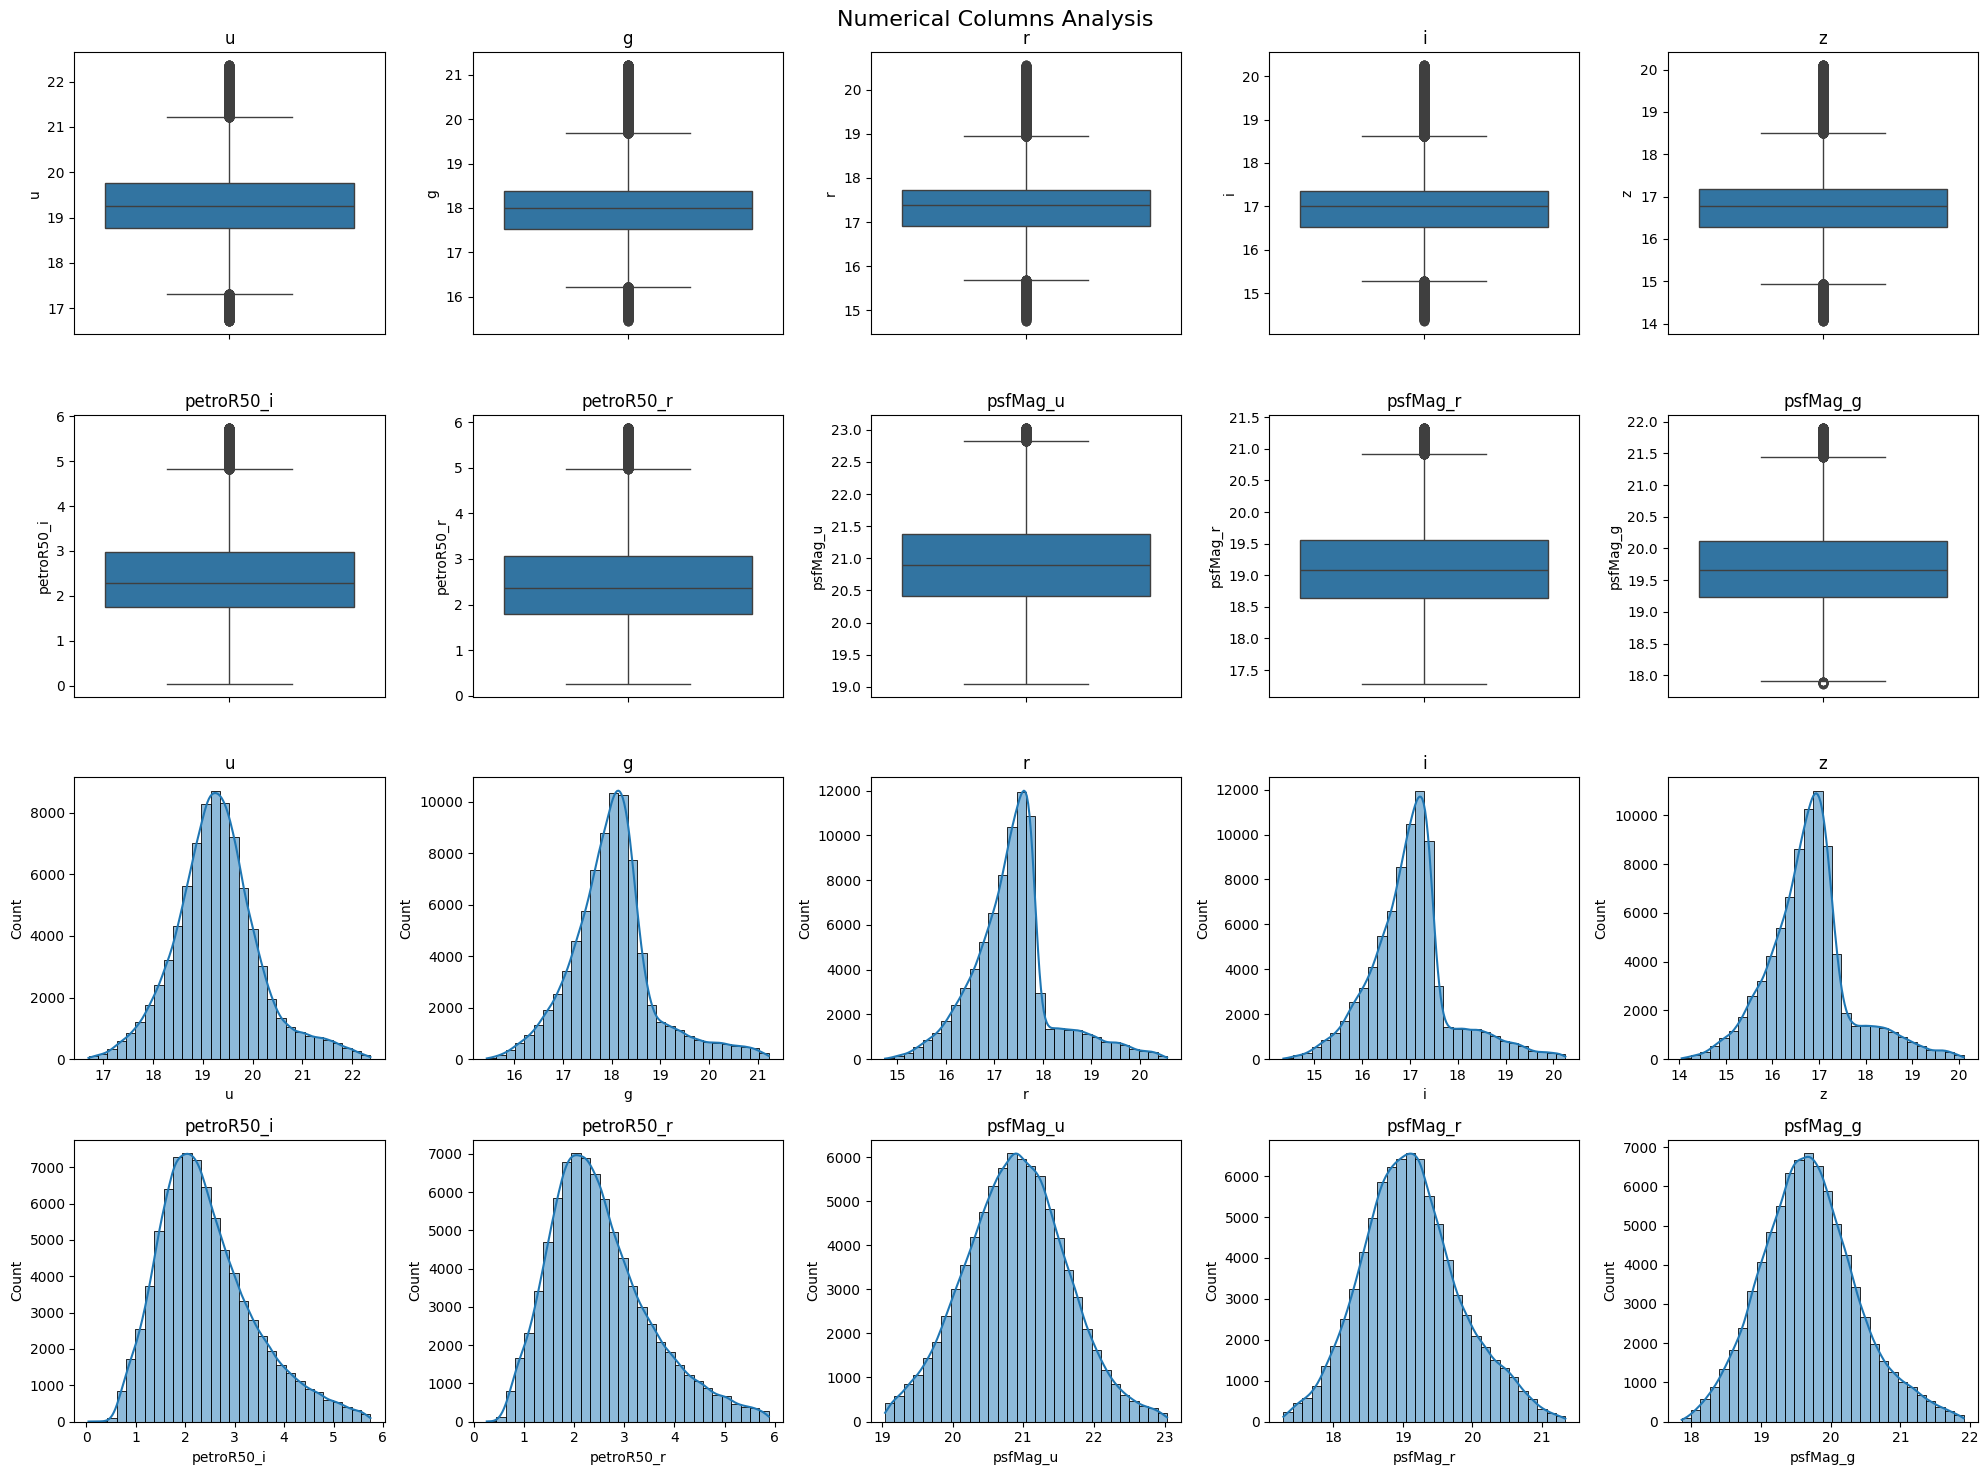

In [ ]:
num_col_analysis(df_clean_sc2, selected_features_sc2, 4, 5, title = 'Numerical Columns Analysis')

In [ ]:
X = df_clean_sc2[selected_features_sc2]
y = df_clean_sc2['redshift']
X.shape, y.shape

((81506, 10), (81506,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((65204, 10), (16302, 10), (65204,), (16302,))

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def evaluate_model(name, model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"{name} Model Evaluation:")
    print(f"MSE: {mse:.5f}, MAE: {mae:.5f}, RMSE: {rmse:.5f}, R2: {r2:.5f}\n")
    return model, y_pred

In [ ]:
lr_model, lr_pred = evaluate_model("Linear Regression", LinearRegression())
rf_model, rf_pred = evaluate_model("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42))
xgb_model, xgb_pred = evaluate_model("XGBoost", XGBRegressor(n_estimators=100, random_state=42))

Linear Regression Model Evaluation:
MSE: 0.00118, MAE: 0.02460, RMSE: 0.03428, R2: 0.70372

Random Forest Model Evaluation:
MSE: 0.00086, MAE: 0.02080, RMSE: 0.02924, R2: 0.78439

XGBoost Model Evaluation:
MSE: 0.00094, MAE: 0.02162, RMSE: 0.03058, R2: 0.76420



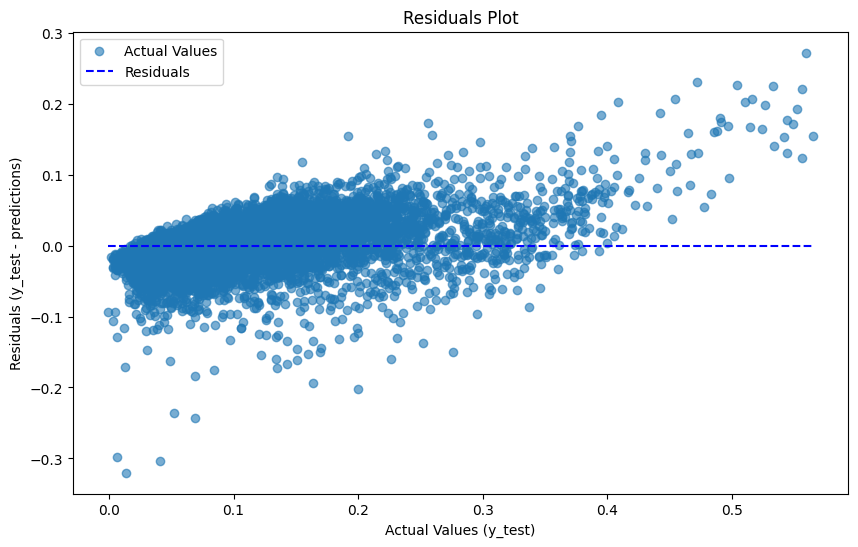

In [ ]:
residuals = y_test - rf_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha = 0.6, label = 'Actual Values')
plt.hlines(0, y_test.min(), y_test.max(), colors = 'blue', linestyles = '--', label = 'Residuals')
plt.legend()
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Residuals (y_test - rf_pred)")
plt.title("Residuals Plot")
plt.show()

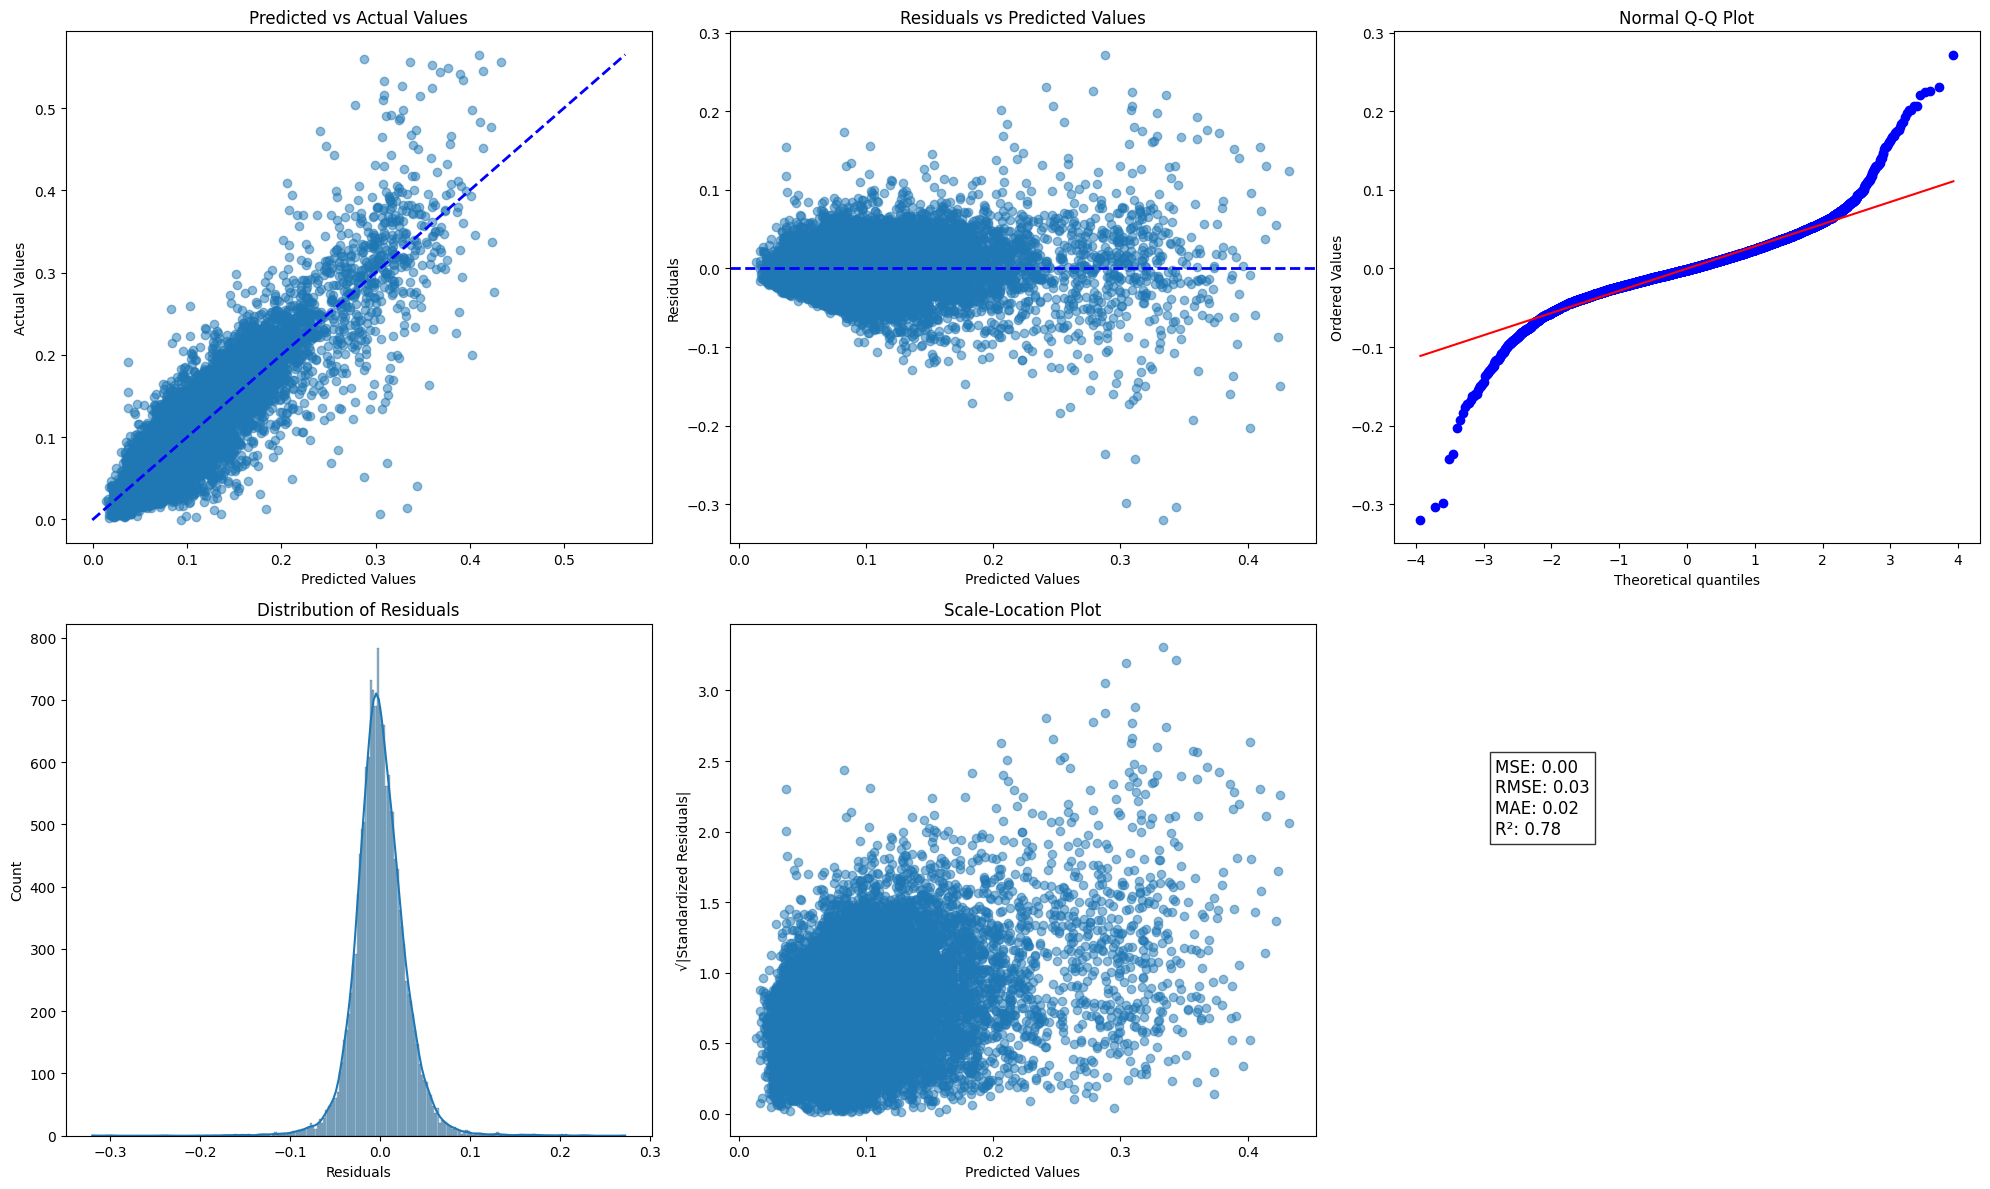

In [ ]:
fig = plt.figure(figsize=(20, 12))

# 1. Predicted vs Actual Values
ax1 = plt.subplot(2, 3, 1)
plt.scatter(rf_pred, y_test, alpha = 0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw = 2)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted vs Actual Values')

# 2. Residuals vs Predicted Values
ax2 = plt.subplot(2, 3, 2)
plt.scatter(rf_pred, residuals, alpha = 0.5)
plt.axhline(0, color = 'b', linestyle = '--', lw = 2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

# 3. QQ Plot
ax3 = plt.subplot(2, 3, 3)
stats.probplot(residuals, dist = 'norm', plot = plt)
plt.title('Normal Q-Q Plot')

# 4. Residuals Distribution
ax4 = plt.subplot(2, 3, 4)
sns.histplot(residuals, kde = True)
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Distribution of Residuals')

# 5. Scale-Location Plot
ax5 = plt.subplot(2, 3, 5)
plt.scatter(rf_pred, np.sqrt(np.abs(residuals / residuals.std())), alpha = 0.5)
plt.xlabel('Predicted Values')
plt.ylabel('√|Standardized Residuals|')
plt.title('Scale-Location Plot')

# Calculate and display performance metrics
mse = mean_squared_error(y_test, rf_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, rf_pred)
r2 = r2_score(y_test, rf_pred)

# Add text box with metrics
metrics_text = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.2f}'
plt.figtext(0.75, 0.3, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(scaler, "scaler_redshift.joblib")

['scaler_redshift.joblib']

In [ ]:
joblib.dump(rf_model, "redshift_model.joblib")

['redshift_model.joblib']